# Two-Layer Neural Network

## 1. Download the CIFAR10 datasets, and load it

You have two ways to download the CIFAR10 datasets:
- cd the path to './CIFAR10/datasets/', and run the 'get_datasets.sh'. Then it will automatically download the datasets and decompress it.
- Enter the CIFAR10 website: http://www.cs.toronto.edu/~kriz/cifar.html and manually download the python version. Then put the datasets in local folder './CIFAR10/datasets/'.

The CIFAR10 datasets named 'cifar-10-batches-py/'

### Setup code

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from CIFAR10.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load the CIFAR10 dataset

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'CIFAR10/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Show some CIFAR10 images

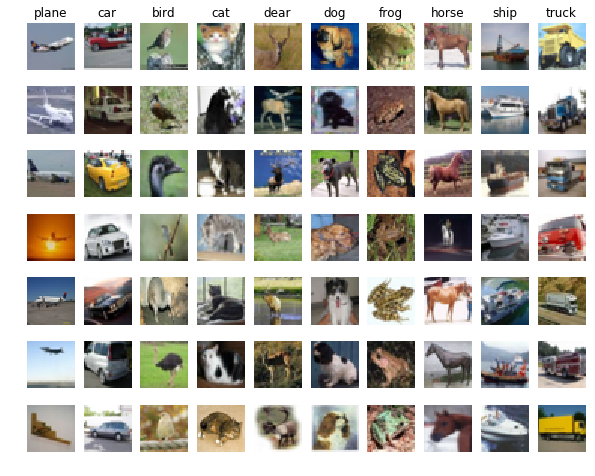

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Subsample the data for more efficient code execution

In [4]:
# Split the data into train, val, test sets and dev sets
num_train = 49000
num_val = 1000
num_test = 1000
num_dev = 500

# Validation set
mask = range(num_train, num_train + num_val)
X_val = X_train[mask]
y_val = y_train[mask]

# Train set
mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]

# Test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## 2. Preprocessing

### Reshape the images data into rows

In [5]:
# Preprocessing: reshape the images data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


### Subtract the mean images

In [6]:
# Processing: subtract the mean images
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

## 3. Define a two-layer neural network

In [7]:
class TwoLayerNet(object):
    def __init__(self, input_size, hidden_size, output_size, std = 1e-4):
        """
        Initialize the model weights
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y, reg = 0.0):
        """
        Two-layer network loss function, vectorized implementation (without loops).
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i]
        - reg: float, regularization strength
        Return:
        - loss: the loss value between predict value and ground truth
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
          Contain 'dW1', 'db1', 'dW2', 'db2'
        """
        N, dim = X.shape
        grads = {}
        
        # input layer ==> hidden layer ==> ReLU ==> output layer ==> Softmax
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        # input layer==> hidden layer
        Z1 = np.dot(X, W1) + b1
        # hidden layer ==> ReLU
        A1 = np.maximum(0, Z1)    # ReLU function
        # ReLU ==> output layer
        scores = np.dot(A1, W2) + b2
        # output layer ==> Softmax
        scores_shift = scores - np.max(scores, axis=1).reshape(-1, 1)
        Softmax_output = np.exp(scores_shift) / np.sum(np.exp(scores_shift), axis=1).reshape(-1, 1)
        loss = -np.sum(np.log(Softmax_output[range(N), list(y)]))
        loss /= N
        loss += 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
        
        # grads
        dS = Softmax_output.copy()
        dS[range(N), list(y)] += -1
        dS /= N
        dW2 = np.dot(A1.T, dS)
        db2 = np.sum(dS, axis=0)
        dA1 = np.dot(dS, W2.T)
        dZ1 = dA1 * (A1 > 0)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0)
        dW2 += reg * W2
        dW1 += reg * W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2
        
        return loss, grads
    
    def predict(self, X):
        """
        Use the trained weights to predict data labels
        Inputs:
        - X: A numpy array of shape (num_test, D) contain the test data
        Outputs:
        - y_pred: A numpy array, predicted labels for the data in X
        """
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        Z1 = np.dot(X, W1) + b1
        A1 = np.maximum(0, Z1)    # ReLU function
        scores = np.dot(A1, W2) + b2
        y_pred = np.argmax(scores, axis=1)
            
        return y_pred
    
    def train(self, X, y, X_val, y_val, learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100, batch_size=200, print_flag=False):
        """
        Train Two-layer neural network classifier using SGD
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i], y[i] = c, 0 <= c <= C
        - X_val: A numpy array of shape (num_val, D) contain the validation data
          consisting of num_val samples each of dimension D
        - y_val: A numpy array of shape (num_val,) contain the validation labels,
          where y_val[i] is the label of X_val[i], y_val[i] = c, 0 <= c <= C
        - learning rate: (float) learning rate for optimization
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: (float) regularization strength
        - num_iters: (integer) numbers of steps to take when optimization
        - batch_size: (integer) number of training examples to use at each step
        - print_flag: (boolean) If true, print the progress during optimization
        Outputs:
        - a dictionary contains the loss_history, train_accuracy_history and val_accuracy_history
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)
        loss_history = []
        train_accuracy_history = []
        val_accuracy_history = []
        
        for t in range(num_iters):
            idx_batch = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[idx_batch]
            y_batch = y[idx_batch]
            loss, grads = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            self.params['W1'] += -learning_rate * grads['W1']
            self.params['b1'] += -learning_rate * grads['b1']
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['b2'] += -learning_rate * grads['b2']
            
            # Every epoch, check train and val accuracy and decay learning rate.
            if t % iterations_per_epoch == 0:
                train_accuracy = np.mean(self.predict(X_batch) == y_batch)
                val_accuracy = np.mean(self.predict(X_val) == y_val)
                train_accuracy_history.append(train_accuracy)
                val_accuracy_history.append(val_accuracy)
                
                # Decay learning rate
                learning_rate *= learning_rate_decay
            
            # print the progress during optimization
            if print_flag and t%100 == 0:
                print('iteration %d / %d: loss %f' % (t, num_iters, loss))
            
        return {
            'loss_history': loss_history,
            'train_accuracy_history': train_accuracy_history,
            'val_accuracy_history': val_accuracy_history,
        }
        
        

## 4. Stochastic Gradient Descent

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, print_flag=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302782
iteration 100 / 1000: loss 2.302411
iteration 200 / 1000: loss 2.299242
iteration 300 / 1000: loss 2.272836
iteration 400 / 1000: loss 2.207163
iteration 500 / 1000: loss 2.081039
iteration 600 / 1000: loss 2.102869
iteration 700 / 1000: loss 2.099161
iteration 800 / 1000: loss 2.041299
iteration 900 / 1000: loss 2.010855
Validation accuracy:  0.286


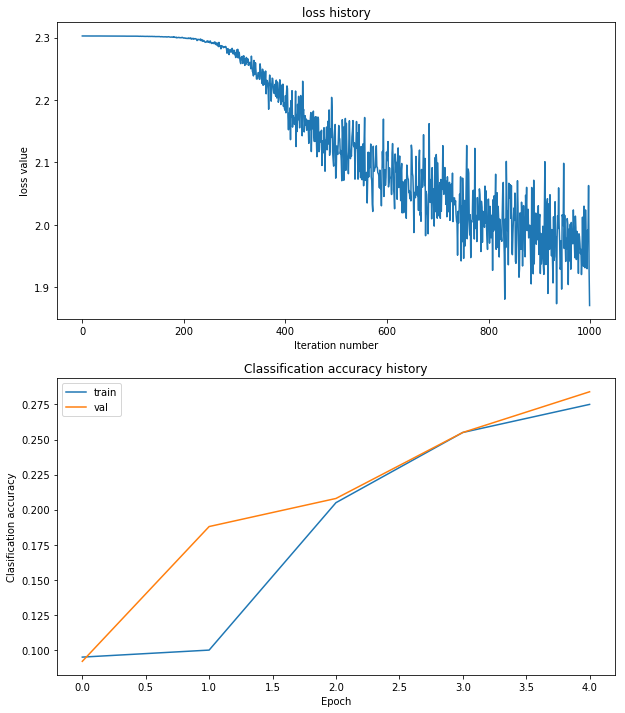

In [9]:
# Plot the loss_history
plt.figure(figsize=(10,12))
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('loss history')
plt.xlabel('Iteration number')
plt.ylabel('loss value')

# Plot the train_accuracy_history & val_accuracy_history
plt.subplot(2, 1, 2)
plt.plot(stats['train_accuracy_history'], label='train')
plt.plot(stats['val_accuracy_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

## 5. Tune your hyperparameters

In [10]:
# Hyperparameters
learning_rates = [1e-4, 5e-4, 9e-4, 13e-4, 15e-4]
regularization_strengths = [0.25, 0.5, 0.75, 1.0]
num_iters = 3000
batch_size = 200
learning_rate_decay = 0.98

# Net structure
input_size = 32 * 32 * 3
hidden_size = [50, 100, 150]
num_classes = 10

# Initialization
best_net = None
best_hidden_size = None
best_val = -1
best_lr = None
best_reg = None
results = {}

# Train the two layers network
for i in range(len(hidden_size)):
    for lr in learning_rates:
        for reg in regularization_strengths:
            net = TwoLayerNet(input_size, hidden_size[i], num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=num_iters, batch_size=batch_size,
                learning_rate=lr, learning_rate_decay=learning_rate_decay,
                reg=reg, print_flag=False)
            train_accuracy = stats['train_accuracy_history'][-1]
            val_accuracy = stats['val_accuracy_history'][-1]
            if val_accuracy > best_val:
                best_lr = lr
                best_reg = reg
                best_val = val_accuracy
                best_net = net
                best_hidden_size = hidden_size[i]
            results[(lr, reg)] = train_accuracy, val_accuracy
            print('hidden_size: %d lr: %e reg: %e train accuracy: %f val accuracy: %f' %
                  (hidden_size[i], lr, reg, results[(lr, reg)][0], results[(lr, reg)][1]))
print('Best hidden_size: %d\nBest lr: %e\nBest reg: %e\ntrain accuracy: %f\nval accuracy: %f' %
     (hidden_size[i], best_lr, best_reg, results[(best_lr, best_reg)][0], results[(best_lr, best_reg)][1]))

hidden_size: 50 lr: 1.000000e-04 reg: 2.500000e-01 train accuracy: 0.410000 val accuracy: 0.407000
hidden_size: 50 lr: 1.000000e-04 reg: 5.000000e-01 train accuracy: 0.415000 val accuracy: 0.399000
hidden_size: 50 lr: 1.000000e-04 reg: 7.500000e-01 train accuracy: 0.370000 val accuracy: 0.400000
hidden_size: 50 lr: 1.000000e-04 reg: 1.000000e+00 train accuracy: 0.420000 val accuracy: 0.403000
hidden_size: 50 lr: 5.000000e-04 reg: 2.500000e-01 train accuracy: 0.595000 val accuracy: 0.494000
hidden_size: 50 lr: 5.000000e-04 reg: 5.000000e-01 train accuracy: 0.595000 val accuracy: 0.505000
hidden_size: 50 lr: 5.000000e-04 reg: 7.500000e-01 train accuracy: 0.495000 val accuracy: 0.483000
hidden_size: 50 lr: 5.000000e-04 reg: 1.000000e+00 train accuracy: 0.600000 val accuracy: 0.475000
hidden_size: 50 lr: 9.000000e-04 reg: 2.500000e-01 train accuracy: 0.670000 val accuracy: 0.496000
hidden_size: 50 lr: 9.000000e-04 reg: 5.000000e-01 train accuracy: 0.675000 val accuracy: 0.510000
hidden_siz

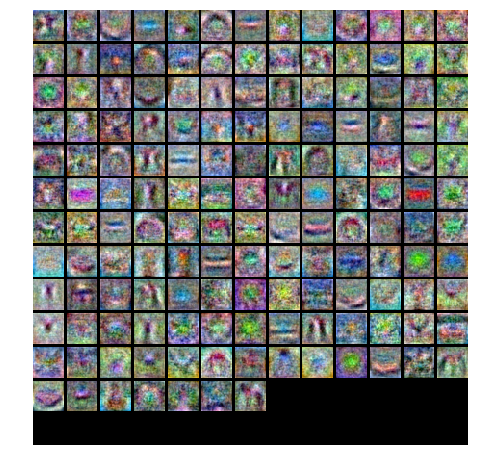

In [13]:
from vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

### Run on the test set

In [14]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.504
